# 0. Постановка задачи

На сайт «СберАвтоподписка» заходят пользователи и совершают некоторые действия (или не совершают).

Имеются данные из Google Analytics (last-click attribution model) по сайту «СберАвтоподписка» в виде двух файлов `ga_sessions.csv` и `ga_hits.csv`.

## Описание файла ga_sessions.csv.

Одна строка = один визит на сайт.

Описание атрибутов:

`session_id` — ID визита;

`client_id` — ID посетителя;

`visit_date` — дата визита;

`visit_time` — время визита;

`visit_number` — порядковый номер визита клиента;

`utm_source` — канал привлечения;

`utm_medium` — тип привлечения;

`utm_campaign` — рекламная кампания;

`utm_keyword` — ключевое слово;

`device_category` — тип устройства;

`device_os` — ОС устройства;

`device_brand` — марка устройства;

`device_model` — модель устройства;

`device_screen_resolution` — разрешение экрана;

`device_brand` — марка устройства;

`device_model` — модель устройства;

`device_screen_resolution` — разрешение экрана;

`device_browser` — браузер;

`geo_country` — страна;

`geo_city` — город.

Входные данные для модели: utm_*, device_*, geo_*

## Описание файла ga_hits.csv.

Одна строка = одно событие в рамках одного визита на сайт.

Описание атрибутов:

`session_id` — ID визита;

`hit_date` — дата события;

`hit_time` — время события;

`hit_number` — порядковый номер события в рамках сессии;

`hit_type` — тип события;

`hit_referer` — источник события;

`hit_page_path` — страница события;

`event_category` — тип действия;

`event_action` — действие;

`event_label` — тег действия;

`event_value` — значение результата действия.

Целевые значения `event_action`:

'sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'

## Описание задачи

Требуется построить модель, которая по входным значениям будет угадывать, совершит ли пользователь с такими параметрами целевое действие при посещении сайта.

Модель должна брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие, 0 в противном случае).

# 1. Подготовка данных

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

## Загрузка данных

In [2]:
sess0 = pd.read_csv('data/ga_sessions.csv', low_memory=False)
sess0.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
hits0 = pd.read_csv('data/ga_hits.csv')
hits0.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [4]:
print('Размер датафрейма "sessions":', sess0.shape)
print('Размер датафрейма "hits":', hits0.shape)

Размер датафрейма "sessions": (1860042, 18)
Размер датафрейма "hits": (15726470, 11)


## Предварительный просмотр

In [5]:
for col in sess0.columns:
    print(f'\t{col} ({sess0[col].dtype} \u2014 {len(sess0[col].value_counts())})', end='')
    if len(sess0[col].value_counts()) < 5000:
        print(':\n', sess0[col].value_counts(), '.\n', sep='')
    else:
        print('.\n')

	session_id (object — 1860042).

	client_id (object — 1391719).

	visit_date (object — 226):
2021-05-24    39453
2021-12-21    30704
2021-05-25    19305
2021-06-29    17367
2021-09-14    16204
              ...  
2021-06-05     2102
2021-05-23     1246
2021-05-21     1110
2021-05-22      986
2021-05-19      877
Name: visit_date, Length: 226, dtype: int64.

	visit_time (object — 85318).

	visit_number (int64 — 537):
1      1376349
2       235656
3        81068
4        41666
5        24271
        ...   
419          1
420          1
421          1
422          1
564          1
Name: visit_number, Length: 537, dtype: int64.

	utm_source (object — 293):
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
                         ...  
GYkgJdhSxirUFPHFiYSe         1
WRHPhoRKhKxaenRCLBfo         1
tjKUGseGMhkLEzdCqBRx         1
wpmatvDuiMutnvmNVPJo         1
BellrslNBZQZaIxVFGXJ         1

In [6]:
for col in hits0.columns:
    print(f'\t{col} ({hits0[col].dtype} \u2014 {len(hits0[col].value_counts())})', end='')
    if len(hits0[col].value_counts()) < 5000:
        print(':\n', hits0[col].value_counts(), '.\n', sep='')
    else:
        print('.\n')

	session_id (object — 1734610).

	hit_date (object — 226):
2021-05-24    513035
2021-12-21    280192
2021-05-25    235805
2021-09-23    168899
2021-05-26    158382
               ...  
2021-07-24     23490
2021-05-23     18773
2021-05-19     14605
2021-05-22     13917
2021-05-21     13497
Name: hit_date, Length: 226, dtype: int64.

	hit_time (float64 — 925887).

	hit_number (int64 — 500):
3      1097355
4       928038
7       667634
8       572076
9       548347
        ...   
479         43
497         43
462         41
494         41
486         41
Name: hit_number, Length: 500, dtype: int64.

	hit_type (object — 1):
event    15726470
Name: hit_type, dtype: int64.

	hit_referer (object — 37873).

	hit_page_path (object — 342715).

	event_category (object — 52):
card_web                         7456998
search_form                      2423605
sub_page_view                    1986074
sub_button_click                 1073471
listing_ads                      1040468
cars                 

## Формирование датасета

In [7]:
# Целевые значения параметра 'event_action':
target_events =['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [8]:
hits0['event_action'].isna().value_counts()

False    15726470
Name: event_action, dtype: int64

Здесь пропусков нет.

Добавим целевую метку, но пока для каждого действия.

In [9]:
hits = hits0.copy()
hits['target'] = hits['event_action'].apply(lambda x: int(x in target_events))

Поставим метки конкретному id сессии (`session_id`). Метка равна 1, если имеется хотя бы одно из целевых действий. В противном случае ставим метку 0. Для этого сначала сгруппируем датафрейм "hits" по столбцу `session_id`.

In [10]:
hits_df = pd.DataFrame(hits.groupby('session_id')['target'].sum()).reset_index()
hits_df['label'] = hits_df['target'].apply(lambda x: int(x != 0))
hits_df = hits_df.drop(['target'], axis=1)
print('Количество меток:')
hits_df['label'].value_counts()

Количество меток:


0    1683850
1      50760
Name: label, dtype: int64

In [11]:
perc = hits_df['label'].value_counts()[1] / len(hits_df)
print(f'Доля целевых меток: {perc:.6f} = {100 * perc:.2f}%')

Доля целевых меток: 0.029263 = 2.93%


Найдём все колонки вида utm_*, device_*, geo_*

Нерелевантных среди них пока не видно.

In [12]:
cols = sess0.columns
input_cols = [col for col in cols if re.match(r'utm_.*|device_.*|geo_.*', col)]
input_cols

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city']

In [13]:
sess_s_ids = set(sess0['session_id']) # Множество сессий из ga_sessions.csv
hits_s_ids = set(hits0['session_id']) # Множество сессий из ga_hits.csv
if len(sess0) == len(sess_s_ids):
    print(f'Значения session_id в "sessions" уникальны (в частности, это значит, что дубликаты отсутствуют), всего их', 
          f'{len(sess_s_ids):_}')
if len(hits0) != len(hits_s_ids):
    print('Значения session_id в "hits" не уникальны')
print('Количество сессий в "sessions", которые отсутствуют в "hits", равно',
      f'{len(sess_s_ids - hits_s_ids):_}')
print('Количество сессий в "hits", которые отсутствуют в "sessions", равно',
      f'{len(hits_s_ids - sess_s_ids):_}')
print(f'Это {100 * len(hits_s_ids - sess_s_ids) / len(hits_s_ids):.2f}% от всех сессий в "hits"')
print('Количество сессий, которые присутствуют в обоих файлах, равно',
      f'{len(hits_s_ids & sess_s_ids):_}',
      f'\nЭто {100 * len(hits_s_ids & sess_s_ids) / len(sess_s_ids):.1f}% от всех сессий в "sessions"')

Значения session_id в "sessions" уникальны (в частности, это значит, что дубликаты отсутствуют), всего их 1_860_042
Значения session_id в "hits" не уникальны
Количество сессий в "sessions", которые отсутствуют в "hits", равно 127_776
Количество сессий в "hits", которые отсутствуют в "sessions", равно 2_344
Это 0.14% от всех сессий в "hits"
Количество сессий, которые присутствуют в обоих файлах, равно 1_732_266 
Это 93.1% от всех сессий в "sessions"


Таким образом можно использовать слияние типа 'inner', чтобы создать метки, потеряв всего 7% данных (ненужных данных в датафрейме "hits" примерно 0.14%, поэтому они практически не замедляют процесс).

In [14]:
df0 = pd.merge(sess0, hits_df, how='inner', on='session_id')
df0 = df0[input_cols + ['label']]
df0.shape

(1732266, 14)

# 2. Разведочный анализ данных

## Заполнение столбцов

Здесь мы заполним пропущенные значения в столбцах `device_brand` и `device_os`.

In [15]:
values = df0['device_brand'].value_counts()
print([i for i in values.index if i[0] == '('])
values

['(not set)']


Apple        503533
Samsung      311641
Xiaomi       269251
Huawei       173828
Realme        17926
              ...  
Smarteo           1
Star              1
Mobiistar         1
Fero              1
Maxvi             1
Name: device_brand, Length: 200, dtype: int64

In [16]:
df0['device_os'].value_counts()

Android          425520
iOS              182597
Windows           81740
Macintosh         23415
Linux              4616
(not set)           309
Chrome OS            65
BlackBerry           24
Tizen                 7
Firefox OS            3
Nokia                 2
Samsung               2
Windows Phone         2
Name: device_os, dtype: int64

Для заполнения одного столбца можно использовать информацию из другого, а так же использовать столбец `device_category`.

In [17]:
df0['device_category'].value_counts()

mobile     1368679
desktop     346891
tablet       16696
Name: device_category, dtype: int64

Можно было бы заполнить теми же значениями, что уже имеются в списке возможных значений, но это даёт не лучший результат (проверено!), потому что теряется часть информации. Поэтому заполним немного другими значениями.

In [18]:
# Функции для заполнения пропусков в 'device_brand' и 'device_os':
def brand_imputer(x):
    x_brand = x['device_brand']
    if pd.isna(x_brand) or x_brand == '(not set)': # Значение '(not set)' тоже считаем пропуском.
        if x['device_os'] in ['iOS', 'Macintosh']:
            return 'Apple_imputed' # Заполненные значения отличаются от оригинальных.
        return 'other'
    return x_brand

def os_imputer(x):
    x_os = x['device_os']
    x_cat = x['device_category']
    if pd.isna(x_os) or x_os == '(not set)':
        if x['device_brand'] == 'Apple':
            if x_cat != 'desktop':
                return 'iOS_imputed'
            return 'Macintosh_imputed'
        if x_cat != 'desktop':
            return 'Android_imputed'
        return 'other'
    return x_os

In [19]:
df = df0.copy()
df['device_brand'] = df.apply(brand_imputer, axis=1)
df['device_os'] = df.apply(os_imputer, axis=1)
df0a = df.copy()

## Пустые значения

Теперь заполним пропущенные значения в остальных столбцах. Для начала выведем количество пустых значений по каждому столбцу.

In [20]:
for col in df.columns:
    print(col, f'{df[col].isna().sum():,}')
    #print(df[col].nunique())
#df.info()
print(f'Всего в дадасете: {len(df):,}')

utm_source 76
utm_medium 0
utm_campaign 195,287
utm_adcontent 304,137
utm_keyword 1,020,752
device_category 0
device_os 0
device_brand 0
device_model 1,717,204
device_screen_resolution 0
device_browser 0
geo_country 0
geo_city 0
label 0
Всего в дадасете: 1,732,266


Столбц `device_model` мало информативен. Удалим его.

Пропуски заменим на 'other'.

Так же некоторые столбцы содержат значения '(not set)' и '(none)'. Его тоже заменим на 'other', поскольку в некоторых столбцах имеется и nan и (no*).

In [21]:
cols_for_drop = ['device_model']

In [22]:
df = df0a.copy()
df = df.drop(cols_for_drop, axis=1)
input_cols_rest = list(df.columns)
input_cols_rest.remove('label') # оставшиеся входные столбцы

for col in input_cols_rest:
    df[col] = df[col].fillna('other')

df = df.replace('(not set)', 'other')
df = df.replace('(none)', 'other')
df1 = df.copy()
df1.shape

(1732266, 13)

## Максимальная вероятность успеха

Даже если максимально переучить модель, она не даст 100%-го предсказания, поскольку имеются строки с одинаковыми входными данными, но разными метками. Посчитаем метрики максимально переобученной модели.

Обозначим вектор со входными данными за $x$, а метку за $y$ (метка $y$ имеет значение 0 или 1). Пусть $n_0(x)$ и $n_1(x)$ <html>&mdash;</html> количество нулей и единиц для данного $x$. Исходя из имеющейся выборки, вероятность того, что входным данным $x$ соответствует $y=1$, равна
$$
 p(x)=\frac{n_1(x)}{n_0(x)+n_1(x)}.
$$

In [23]:
gr = df1.groupby(input_cols_rest)[['label']]
px = gr.transform(lambda x: x.sum() / x.count())

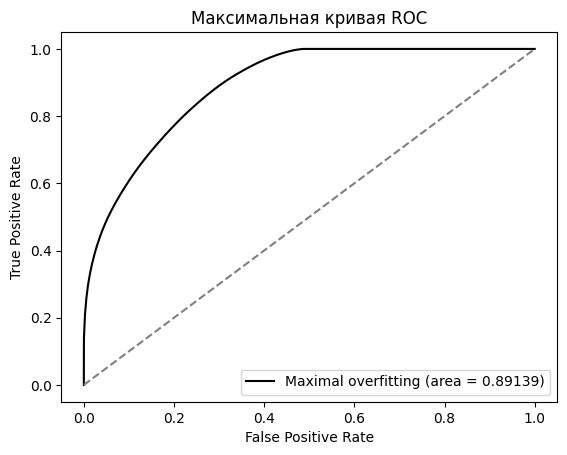

In [24]:
# Построим кривую ROC для максимального переобучения:

fpr_max, tpr_max, threshold = roc_curve(df1['label'], px['label'])
roc_auc_max = auc(fpr_max, tpr_max)
plt.plot(fpr_max, tpr_max, color='black', label=f'Maximal overfitting (area = {roc_auc_max:.5f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.title('Максимальная кривая ROC')
plt.show()

При имеющихся данных невозможно подняться выше этой кривой.

Максимально возможное значение AUC ROC равно $$AUC\_ROC_{max} = 0.8914$$

## Преобразование типов

Преобразуем разрешение экрана в численные характеристики: общее количество пикселей, а так же количество пикселей по горизонтали и вертикали.

In [25]:
df = df1.copy()
df['pixel'] = df['device_screen_resolution'].apply(lambda x: x.split('x')).apply(lambda x: int(x[0])*int(x[1]))
df['x_pixel'] = df['device_screen_resolution'].apply(lambda x: x.split('x')).apply(lambda x: int(x[0]))
df['y_pixel'] = df['device_screen_resolution'].apply(lambda x: x.split('x')).apply(lambda x: int(x[1]))

df = df.drop(['device_screen_resolution'], axis=1)

df2 = df.copy()
df2.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,label,pixel,x_pixel,y_pixel
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,259200,360,720
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,328790,385,854
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,259200,360,720
3,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,other,mobile,Android_imputed,Xiaomi,Chrome,Russia,Moscow,0,308898,393,786
4,kjsLglQLzykiRbcDiGcD,cpc,other,other,other,mobile,Android_imputed,Xiaomi,Chrome,Russia,Moscow,0,308898,393,786


## Выбросы

In [26]:
def visual(df, cols):
    for col in cols:
        fig, ax = plt.subplots(2,1, figsize=(10,7), sharex=True)
        ax[0].hist(df[col])
        ax[1].boxplot(df[col], vert=False)
        plt.xlabel(col)
        ax[0].set_ylabel('Частота')
        fig.suptitle(f'Гистограмма и boxplot для "{col}"')
        plt.show()

Посмотрим на картину распределения разрешения экрана с точки зрения выбросов сверху.

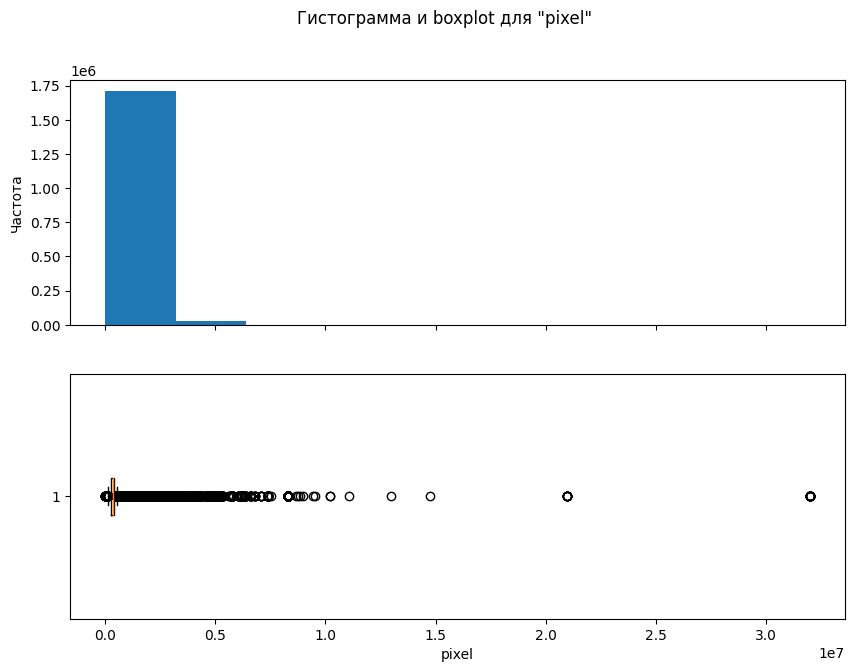

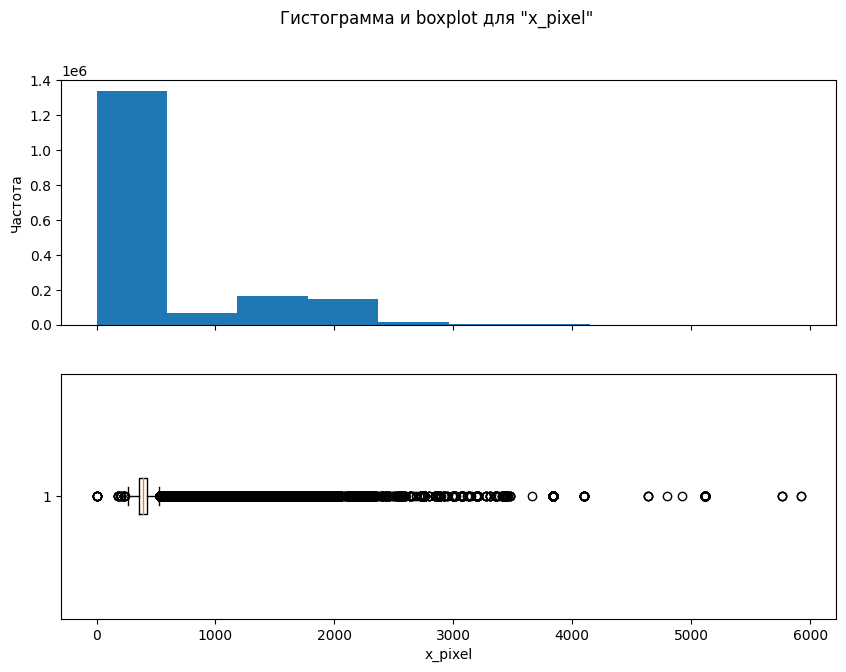

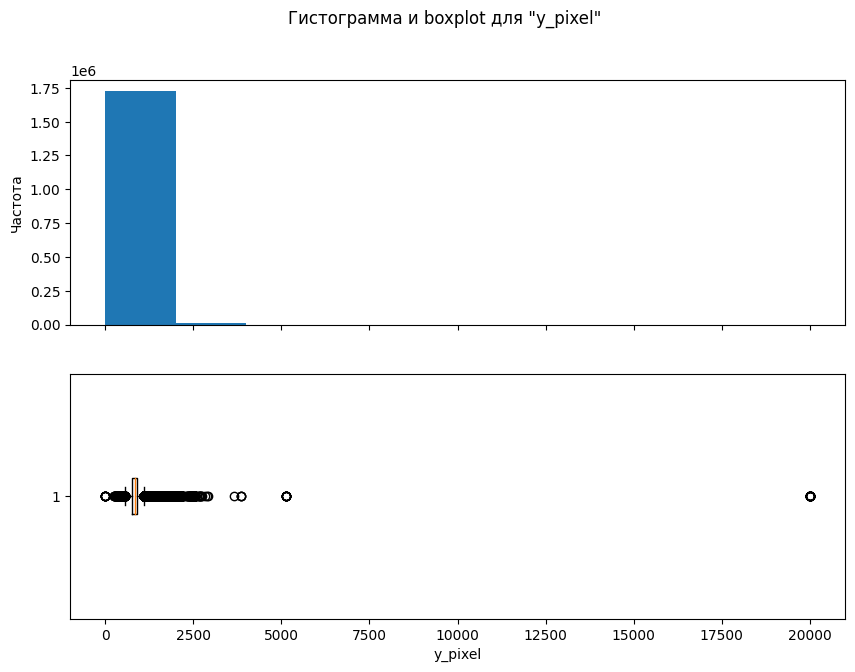

In [27]:
df = df2.copy()
visual(df, ['pixel', 'x_pixel', 'y_pixel'])

Распределение количества пикселей вполне соответствует современной реальности.

Однако большие значения могут неправильно обучить модель.

Лучше их ограничить или взять логарифм.

Проверим на выбросы снизу.

In [28]:
df[df['pixel'] < 50000]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,label,pixel,x_pixel,y_pixel
41296,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,KCcEkEaKEtUilBVMoCAi,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
58761,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,other,desktop,other,other,Edge,Russia,Saint Petersburg,0,0,0,0
108556,BHcvLfOaCWvWTykYqHVe,cpc,other,other,other,mobile,Android_imputed,Huawei,YaBrowser,Russia,Vladivostok,0,0,0,0
250224,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0
434853,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,YaBrowser,Russia,Moscow,0,0,0,0
753209,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,desktop,Linux,other,Chrome,Russia,Saint Petersburg,0,0,0,0
917653,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,other,mrrsABvDmholqItQOtcL,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
1446270,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,Chrome,Russia,Saint Petersburg,0,0,0,0
1576389,bByPQxmDaMXgpHeypKSM,referral,hkvDVxqLOzGjGaoNiNzN,sYzBROYhjSDbFZCpzGyf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0


In [29]:
df[df['x_pixel'] < 100]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,label,pixel,x_pixel,y_pixel
41296,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,KCcEkEaKEtUilBVMoCAi,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
58761,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,other,desktop,other,other,Edge,Russia,Saint Petersburg,0,0,0,0
108556,BHcvLfOaCWvWTykYqHVe,cpc,other,other,other,mobile,Android_imputed,Huawei,YaBrowser,Russia,Vladivostok,0,0,0,0
250224,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0
434853,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,YaBrowser,Russia,Moscow,0,0,0,0
753209,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,desktop,Linux,other,Chrome,Russia,Saint Petersburg,0,0,0,0
917653,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,other,mrrsABvDmholqItQOtcL,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
1446270,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,Chrome,Russia,Saint Petersburg,0,0,0,0
1576389,bByPQxmDaMXgpHeypKSM,referral,hkvDVxqLOzGjGaoNiNzN,sYzBROYhjSDbFZCpzGyf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0


In [30]:
df[df['y_pixel'] < 250]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,label,pixel,x_pixel,y_pixel
41296,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,KCcEkEaKEtUilBVMoCAi,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
58761,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,other,desktop,other,other,Edge,Russia,Saint Petersburg,0,0,0,0
108556,BHcvLfOaCWvWTykYqHVe,cpc,other,other,other,mobile,Android_imputed,Huawei,YaBrowser,Russia,Vladivostok,0,0,0,0
250224,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0
434853,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,YaBrowser,Russia,Moscow,0,0,0,0
753209,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,desktop,Linux,other,Chrome,Russia,Saint Petersburg,0,0,0,0
917653,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,other,mrrsABvDmholqItQOtcL,desktop,Windows,other,Chrome,Russia,Moscow,0,0,0,0
1446270,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,other,mobile,Android_imputed,Samsung,Chrome,Russia,Saint Petersburg,0,0,0,0
1576389,bByPQxmDaMXgpHeypKSM,referral,hkvDVxqLOzGjGaoNiNzN,sYzBROYhjSDbFZCpzGyf,other,desktop,other,other,Chrome,Russia,Saint Petersburg,0,0,0,0


Все выбросы снизу имеют только нулевые значения.

Заменим их на медиану, поскольку нулевое значение разрешения эквивалентно отсутствию значения, а медиана не очень чувствительна к выбросам.

In [31]:
df = df2.copy()
mx = df['x_pixel'].median()
my = df['y_pixel'].median()
for i in df.index:
    if df.loc[i, 'pixel'] == 0:
        df.loc[i, 'pixel'] = int(mx*my)
        df.loc[i, 'x_pixel'] = int(mx)
        df.loc[i, 'y_pixel'] = int(my)
df3 = df.copy()

# 3. Новые фичи

## Пиксели экрана

Как и обещали выше берём логарифм от количества пикселей. Обычное число тоже оставим, но немного ограничим.

In [32]:
df = df3.copy()
df['log_pixel'] = df['pixel'].apply(lambda x: math.log(x))
df['pixel'] = df['pixel'].apply(lambda x: min(x, 5 * 10**6))
df['log_x_pixel'] = df['x_pixel'].apply(lambda x: math.log(x))
df['x_pixel'] = df['x_pixel'].apply(lambda x: min(x, 2500))
df['log_y_pixel'] = df['y_pixel'].apply(lambda x: math.log(x))
df['y_pixel'] = df['y_pixel'].apply(lambda x: min(x, 2000))
df4 = df.copy()
df4.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,label,pixel,x_pixel,y_pixel,log_pixel,log_x_pixel,log_y_pixel
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,259200,360,720,12.465355,5.886104,6.579251
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,328790,385,854,12.703175,5.953243,6.749931
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,259200,360,720,12.465355,5.886104,6.579251
3,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,other,mobile,Android_imputed,Xiaomi,Chrome,Russia,Moscow,0,308898,393,786,12.640766,5.973810,6.666957
4,kjsLglQLzykiRbcDiGcD,cpc,other,other,other,mobile,Android_imputed,Xiaomi,Chrome,Russia,Moscow,0,308898,393,786,12.640766,5.973810,6.666957


Посмотрим на корреляции с целевой переменной до и после сделанного преобразования.

In [33]:
df3.corrwith(df['label'], numeric_only=True)

label      1.000000
pixel      0.004602
x_pixel    0.006705
y_pixel    0.009125
dtype: float64

In [34]:
df4.corrwith(df['label'], numeric_only=True)

label          1.000000
pixel          0.004974
x_pixel        0.007045
y_pixel        0.010376
log_pixel      0.010880
log_x_pixel    0.007598
log_y_pixel    0.015901
dtype: float64

Новые фичи лучше коррелируют, особенно логарифмированные.

## Города

Выведем количество значений в столбце `geo_city`.

In [35]:
df4['geo_city'].value_counts().count()

2389

Имеется 2389 значений. Это перегружает модель, хотя информации не очень много.

Посчитаем количество вхождений каждого города с датасет.

Если объединим города близкие по количеству, не трогая города с большим вхождением,
то мы не потеряем много информации и сократим число значений.

In [36]:
def city_reduce(df):
    x = float(df['gr'])
    if x < 1000:
        return str(int(math.log(x)))
    else:
        return df['geo_city']

In [37]:
df = df4.copy()
gr = df.groupby('geo_city')[['geo_city']].transform('count')
df['gr'] = gr['geo_city']
df['geo_city'] = df.apply(city_reduce, axis=1)
df = df.drop(['gr'], axis=1)
df5 = df.copy()

In [38]:
df5['geo_city'].value_counts().count()

125

Теперь в колонке `geo_city` всего 125 значений, что даёт лишь 125 one-hot колонок вместо 2389.

## Трафик

Добавим ещё 2 фичи: органический и мобильный трафик.

In [39]:
df = df5.copy()
# Органический трафик соответствует значениям utm_medium равным 'organic', 'referral' и 'other'.
df['organic_traffic'] = df['utm_medium'].apply(lambda x: int(x in ['organic', 'referral', 'other']))
# Мобильный трафик соответствует значению device_category ='mobile'.
df['mobile_traffic'] = df['device_category'].apply(lambda x: int(x == 'mobile'))
df6 = df.copy()

# 4. Обучение моделей

## Нормализация и разделение

In [40]:
#df = df4.copy()
df = df6.copy()
target = 'label'
X = df.drop([target], axis=1)
y = df[target]

col_transformer = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('ecoder', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
])

X = col_transformer.fit_transform(X)

train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.2)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1385812, 2783), (346454, 2783), (1385812,), (346454,))

## Логистическая регрессия

Простейшая модель, подходящая для данной задачи <html>&mdash;</html> логистическая регрессия.

In [41]:
logis = LogisticRegression(solver='newton-cg')

In [42]:
param_grid = {'C': [0.2, 0.5, 1]}
grid_search_logis = GridSearchCV(logis, param_grid, cv=5, scoring='roc_auc', refit=False)
grid_search_logis.fit(train_x, train_y)
grid_search_logis.best_params_

{'C': 0.5}

In [43]:
cv_res = grid_search_logis.cv_results_
for p, m, s, t in zip(cv_res['params'], cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['mean_fit_time']):
    print(p, f'\u2014 mean: {m:.5f}, std: {s:.5f}, mean fit time: {t:.0f} s.')

{'C': 0.2} — mean: 0.68436, std: 0.00085, mean fit time: 35 s.
{'C': 0.5} — mean: 0.68444, std: 0.00074, mean fit time: 46 s.
{'C': 1} — mean: 0.68419, std: 0.00067, mean fit time: 61 s.


In [44]:
logis = LogisticRegression(C=0.5, solver='newton-cg')
logis.fit(train_x, train_y);

Попробуем также метод стохастического градиентного спуска.

In [45]:
sgd = SGDClassifier(loss='log_loss', alpha=1e-05, penalty='elasticnet', l1_ratio=0.05)

In [46]:
param_grid = {'alpha': [1e-06, 1e-05, 5e-05],
              'l1_ratio': [0.01, 0.10, 0.5]
             }
grid_search_sgd = GridSearchCV(sgd, param_grid, cv=5, scoring='roc_auc', refit=False)
grid_search_sgd.fit(train_x, train_y)
grid_search_sgd.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.1}

In [47]:
cv_res = grid_search_sgd.cv_results_
for p, m, s, t in zip(cv_res['params'], cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['mean_fit_time']):
    print(p, f'\u2014 mean: {m:.5f}, std: {s:.5f}, mean fit time: {t:.0f} s.')

{'alpha': 1e-06, 'l1_ratio': 0.01} — mean: 0.64754, std: 0.01235, mean fit time: 7 s.
{'alpha': 1e-06, 'l1_ratio': 0.1} — mean: 0.65442, std: 0.00858, mean fit time: 7 s.
{'alpha': 1e-06, 'l1_ratio': 0.5} — mean: 0.64801, std: 0.01853, mean fit time: 6 s.
{'alpha': 1e-05, 'l1_ratio': 0.01} — mean: 0.67288, std: 0.00565, mean fit time: 4 s.
{'alpha': 1e-05, 'l1_ratio': 0.1} — mean: 0.67732, std: 0.00225, mean fit time: 4 s.
{'alpha': 1e-05, 'l1_ratio': 0.5} — mean: 0.66866, std: 0.01261, mean fit time: 3 s.
{'alpha': 5e-05, 'l1_ratio': 0.01} — mean: 0.67496, std: 0.00355, mean fit time: 3 s.
{'alpha': 5e-05, 'l1_ratio': 0.1} — mean: 0.67581, std: 0.00159, mean fit time: 3 s.
{'alpha': 5e-05, 'l1_ratio': 0.5} — mean: 0.67147, std: 0.00297, mean fit time: 3 s.


In [48]:
sgd = SGDClassifier(loss='log_loss', alpha=1e-05, penalty='elasticnet', l1_ratio=0.1)
sgd.fit(train_x, train_y);

Стохастический метод работает гораздо быстрее, но он немного менее точен.

## Нейронные сети

In [49]:
time = datetime.datetime.now()
mlp2 = MLPClassifier(activation='logistic', solver='adam', max_iter=500, hidden_layer_sizes=(100, 30))
mlp2.fit(train_x, train_y)
str(datetime.datetime.now() - time)

'0:15:54.671531'

Нейронные сети слишком долго обучаются на нашем датасете даже после всех упрощений.

Поэтому опустим подгонку параметров и кросс-валидацию.

## Сравнение и оценка моделей

In [50]:
# Функция, которая вычисляет порог по выходным данным функции roc_curve
def thr(fpr, tpr, threshold):
    assert len(fpr) == len(tpr) == len(threshold)
    # Пороговое значение вероятности выбирается так,
    # чтобы разность True Positive Rate - False Positive Rate
    # была максимальна:
    i = np.argmax(tpr - fpr)
    return threshold[i]

In [51]:
models = [logis, sgd, mlp2]

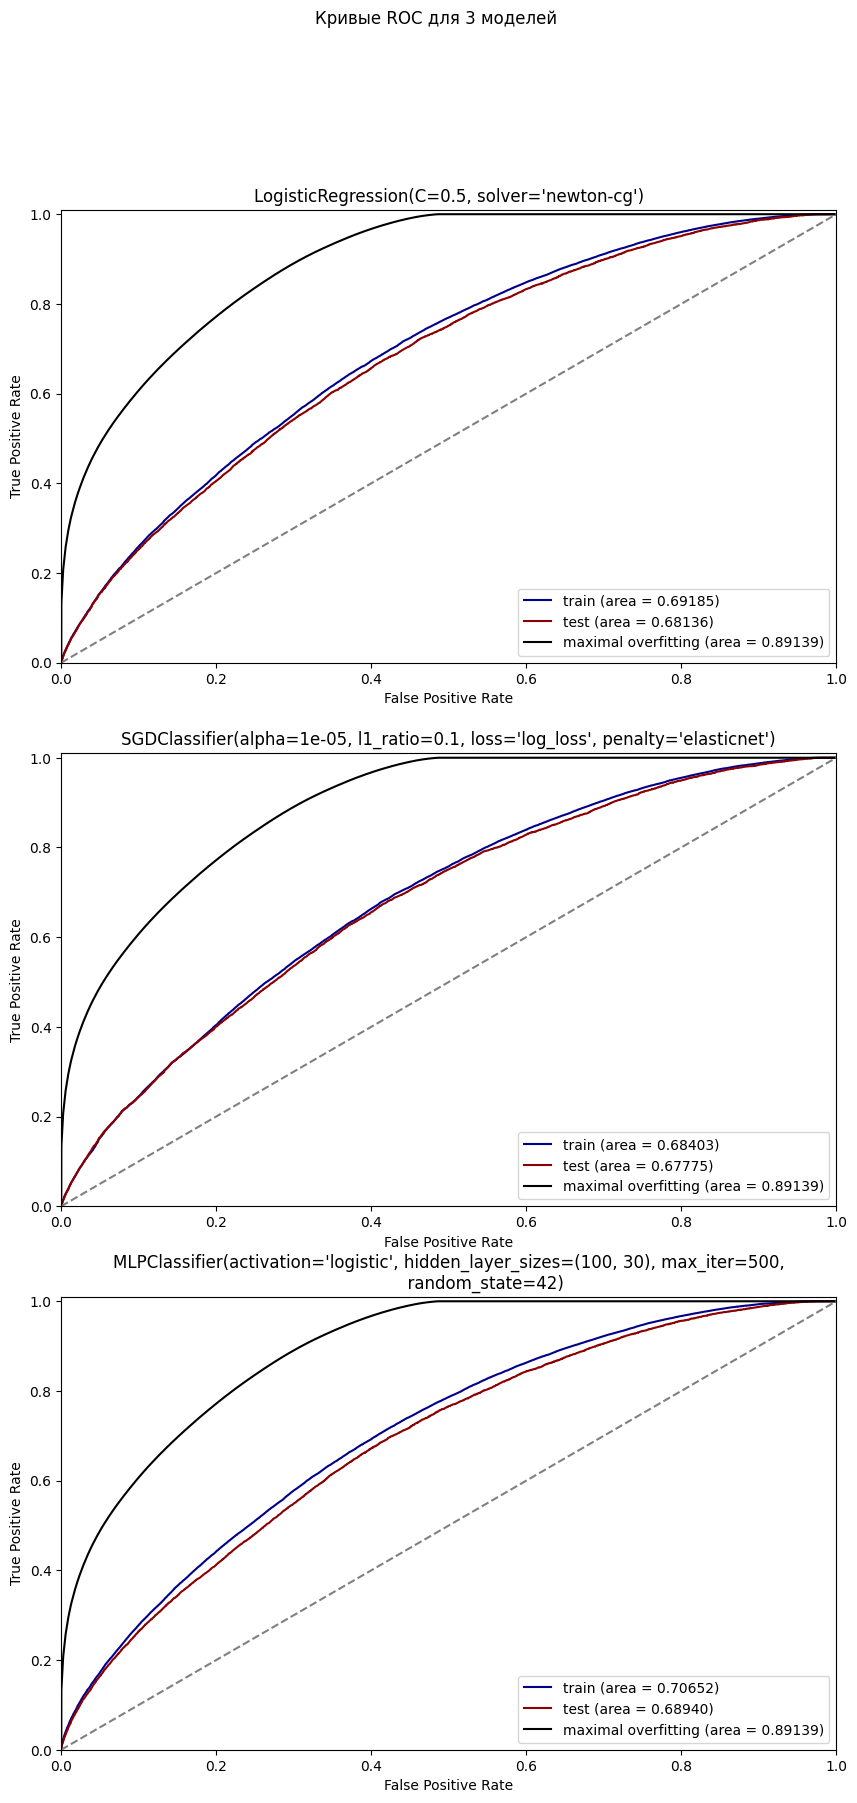

In [52]:
# Построим графики и заодно узнаем пороговые значения вероятности:

fig, ax = plt.subplots(len(models), 1, figsize=(10, 2 + 6*len(models)))

threshold_train = {}
threshold_test = {}

for i, m in enumerate(models):
    proba_train = m.predict_proba(train_x)[:, 1]
    proba_test = m.predict_proba(test_x)[:, 1]
    
    fpr, tpr, threshold = roc_curve(train_y, proba_train)
    threshold_train[m] = thr(fpr, tpr, threshold)
    roc_auc = auc(fpr, tpr)
    ax[i].plot(fpr, tpr, color='darkblue', label=f'train (area = {roc_auc:.5f})')

    fpr, tpr, threshold = roc_curve(test_y, proba_test)
    threshold_test[m] = thr(fpr, tpr, threshold)
    roc_auc = auc(fpr, tpr)
    ax[i].plot(fpr, tpr, color='darkred', label=f'test (area = {roc_auc:.5f})')
    
    ax[i].plot(fpr_max, tpr_max, color='black', label=f'maximal overfitting (area = {roc_auc_max:.5f})')

    ax[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.01])
    ax[i].set_title(f'{m}')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].legend(loc="lower right")

fig.suptitle(f'Кривые ROC для {len(models)} моделей')
plt.show()

In [53]:
# Выведем отдельно метрики:
for m in models:
    proba_train = m.predict_proba(train_x)[:, 1]
    proba_test = m.predict_proba(test_x)[:, 1]
    print(f'Модель {m}.\n roc_auc: train \u2014 {roc_auc_score(train_y, proba_train):.7f}, \
test \u2014 {roc_auc_score(test_y, proba_test):.7f}')

Модель LogisticRegression(C=0.5, solver='newton-cg').
 roc_auc: train — 0.6918458, test — 0.6813585
Модель SGDClassifier(alpha=1e-05, l1_ratio=0.1, loss='log_loss', penalty='elasticnet').
 roc_auc: train — 0.6840268, test — 0.6777548
Модель MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 30), max_iter=500,
              random_state=42).
 roc_auc: train — 0.7065213, test — 0.6894040


Модели не переобучены.

Лучший результат показывает нейронная сеть с 2 скрытыми слоями: $AUC\_ROC = 0.6894$ на тестовой выборке (при максимально возможном значении $AUC\_ROC_{max} = 0.8914$).

In [54]:
# Пороговые значения:
for m in models:
    print(m, threshold_test[m], threshold_train[m], sep='\n')

LogisticRegression(C=0.5, solver='newton-cg')
0.027617624826591625
0.028640947279580223
SGDClassifier(alpha=1e-05, l1_ratio=0.1, loss='log_loss', penalty='elasticnet')
0.02626529972202638
0.02605449024688761
MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 30), max_iter=500,
              random_state=42)
0.02662859958728451
0.026857354786228024


Пороговое значение примерно равно доле целевых меток: 0.03 = 3%.

Посмотрим на confusion matrix для последней модели (mlp2).

In [55]:
threshold_prob = 0.03
predict_test = (proba_test > threshold_prob).astype(int)
print(confusion_matrix(test_y, predict_test),
      confusion_matrix(test_y, predict_test, normalize='true'),
      confusion_matrix(test_y, predict_test, normalize='pred'),
      sep='\n\n'
)

[[217106 119223]
 [  3843   6282]]

[[0.64551674 0.35448326]
 [0.37955556 0.62044444]]

[[0.98260685 0.94994622]
 [0.01739315 0.05005378]]


Итого.

Лучшая модель: MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 30), max_iter=500)

Метрика 𝐴𝑈𝐶 𝑅𝑂𝐶 для неё равна 0.6894


Пороговое значение вероятности: 0.03 